# ⚡️Summary ⚡️
In this notebook we look to run Multiple Tuned models each model was tuned in our single model tuning notebook

In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

import gc
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import log_loss, mean_squared_error , mean_absolute_error, r2_score
from sklearn.model_selection import KFold,  RepeatedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

from sklearn.linear_model import Ridge, LinearRegression, HuberRegressor, Lasso,LassoCV,SGDRegressor
from sklearn.svm import SVR

import optuna
import shap
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor

#### Project Parameters
This determines how and what will be run

In [2]:
target = "Strength" #Target column that we will be predicting, this is here for quick reference 

# Different scaling options
SCALING = False
SCALER = QuantileTransformer(output_distribution = "normal") #RobustScaler()

# Feature engineering and model training options
ADD_DATA = True
TEST_ON_GENERATED_ONLY = True
EPOCHS= 2000
OUTLIERS_DROP=False
NUM_FOLDS = 5
NUM_SPLITS = 3

SHAP_VALS = False
CALIBRATION = "linear"

# Notebook settings
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

# 💾 Load Data Data 💾

In [3]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv", index_col = 0)
df_test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv", index_col = 0)
sub = pd.read_csv("/kaggle/input/playground-series-s3e9/sample_submission.csv",index_col = 0)
df_train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...
5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30


In [4]:
if ADD_DATA:
    add_data = pd.read_csv('/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv')
    
    print("length of additional data", len(add_data))
    print("length of original data", len(df_train))
    df_train['is_generated'] = 1
    df_test['is_generated'] = 1
    add_data['is_generated'] = 0
    add_data.columns =df_train.columns

    df_train = pd.concat([df_train, add_data],axis=0, ignore_index=True)
df_train

length of additional data 1030
length of original data 5407


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1
...,...,...,...,...,...,...,...,...,...,...
6432,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
6433,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0
6434,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0
6435,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0


## Helper functions 

In [5]:
def base_model(X_trn,y_trn,X_tst,y_tst, name,model_in, X_in, test_in, print_scores = True):
    
    if name in ["lightgbm"]:
        model_in.fit(X_trn,y_trn,
              eval_set=[(X_tst,y_tst)],
              callbacks= [lgb.log_evaluation(-1), lgb.early_stopping(30,verbose=0)])
        
    elif name in ["xgboost"]:
        model_in.fit(X_trn,y_trn,
                     eval_set=[(X_tst,y_tst)],
                  verbose= 0
                 )
    elif name in ["catboost"]:
        model_in.fit(X_trn,y_trn,
                  eval_set=[(X_tst,y_tst)],
                  early_stopping_rounds=30,
                  verbose= 0
                 )          
    else:
        model_in.fit(X_trn,y_trn)

    val_preds = model_in.predict(X_tst)
    trn_preds = model_in.predict(X_in)
    test_preds = model_in.predict(test_in)
    
    score_trn =mean_squared_error(y, trn_preds)**0.5
    score_val = mean_squared_error(y_tst, val_preds )**0.5
    
    if print_scores:
        print("\nTrn Score:",score_trn)
        print("Val Score:",score_val)
        #print("Val logloss", log_loss(y,trn_preds_base))
    
    return test_preds, trn_preds, val_preds, score_trn, score_val, model_in

In [6]:
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [7]:
def detect_outliers(data):
    outlier_percents = {}
    for column in data.columns:
        q1 = np.quantile(data[column], 0.25)
        q3 = np.quantile(data[column], 0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outlier_percent = (outliers.shape[0] / data.shape[0]) * 100
        outlier_percents[column] = outlier_percent
        
    outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage')

# 📃 Quick Analysis 📃

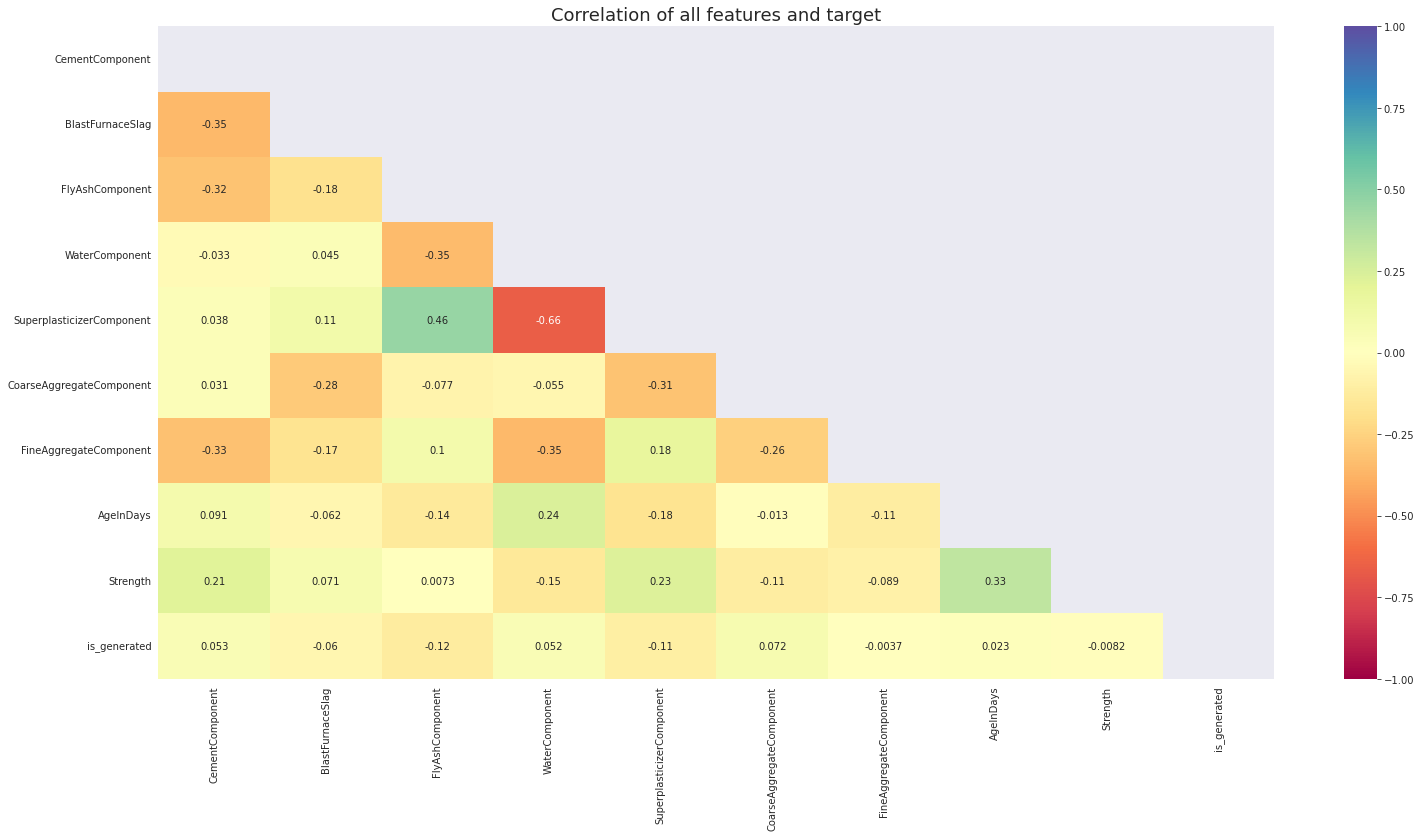

In [8]:
plt.figure(figsize = (25,12))

corr = pd.concat((df_train, df_test), axis =0).corr()
upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "Spectral", annot = True, mask = upper_triangle)
plt.title("Correlation of all features and target", fontsize= 18)
plt.show()

# 🎯 Feature Engineering 🎯
* Here we create features and process our data, by steps that were identified in our EDA

In [9]:
df_trn = df_train.copy(deep = True)
df_tst = df_test.copy(deep = True)
df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1
...,...,...,...,...,...,...,...,...,...,...
6432,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
6433,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0
6434,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0
6435,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0


## Duplicates
* We have a large number of duplicates with differing target values. This is irregular but also logical (i.e. your cement strengh is not always the same) as we may be missing some additonal variables. 
* We therefore want to include these duplicates but help our model file a way to distinguish some middle ground ---lets uses groupby.mean()

In [10]:
print("Duplicated rows:",df_trn.duplicated().sum())
print("Duplicated rows, less target:",df_trn.drop(target,axis =1).duplicated().sum())
print("Length of train:",len(df_trn))
print(f"Percentage as duplicates (less target): {df_trn.drop(target,axis =1).duplicated().sum()/len(df_trn)*100:.2f}%" )

df_trn.drop_duplicates(inplace = True,ignore_index  = True)
#df_tst.drop_duplicates(inplace = True,ignore_index  = True)
print(df_trn.duplicated().sum())

Duplicated rows: 25
Duplicated rows, less target: 2439
Length of train: 6437
Percentage as duplicates (less target): 37.89%
0


### Additional Features

In [11]:
def Additional_Features(df_in):
    df = df_in.copy(deep = True)
    
    for col in df_test.drop("is_generated",axis =1).columns: 
        grp_target = df_trn[df_trn.drop(target,axis =1).duplicated()].groupby(col).mean()[target]
        if 0 in grp_target.index:
            bins = list(grp_target.index)+ [max(df_trn[col])+1]
        else: 
            bins = [0] + list(grp_target.index)
        
        #add cols
        df[f"{col}_grp_mean"] = pd.cut(df[col], bins=bins, labels =grp_target.values )
        df[f"{col}_grp_mean"] = df[f"{col}_grp_mean"].astype('float64').fillna(0)

    return df

df_trn = Additional_Features(df_trn)
df_tst = Additional_Features(df_tst)
df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated,CementComponent_grp_mean,BlastFurnaceSlag_grp_mean,FlyAshComponent_grp_mean,WaterComponent_grp_mean,SuperplasticizerComponent_grp_mean,CoarseAggregateComponent_grp_mean,FineAggregateComponent_grp_mean,AgeInDays_grp_mean
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1,39.276327,0.000000,0.000,36.387000,0.000000,36.985248,37.088376,17.649962
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1,38.840000,37.260000,36.955,35.975000,50.408333,44.691111,55.160000,37.397488
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1,29.377143,27.623226,0.000,32.085729,0.000000,37.340000,30.250000,37.397488
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1,34.334118,50.408333,0.000,41.083709,0.000000,40.688405,38.541071,43.053415
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1,38.504211,38.965000,0.000,30.644892,0.000000,38.808889,38.808889,42.285341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6407,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0,35.975000,33.418182,43.590,61.865000,33.856667,29.930000,35.797500,37.397488
6408,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0,27.150000,0.000000,45.294,31.900000,27.150000,37.360000,48.280000,37.397488
6409,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0,65.910000,56.480000,48.280,39.108000,44.650000,55.640000,29.440000,37.397488
6410,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0,19.690000,45.910000,0.000,34.505000,38.300000,34.505000,33.200385,37.397488


### Drop Cols 
Below we will create sets of columns to drop for each model. These columns will be identified by trial and error as well as well as Recursive Feature Engineering 

In [12]:
all_drop_cols = []

#keep these 
cat_cols = [col for col in df_trn.columns if col not in [target]]
lgb_cols =[col for col in df_trn.columns if col not in [target]]
xgb_cols = [col for col in df_trn.columns if col not in [target]]
rf_cols = [col for col in df_trn.columns if col not in [target]]

In [13]:
lin_cols = df_tst.columns

### Inf and nan values
Check to see if we have any Nan or infinte values 

In [14]:
print(np.isinf(df_trn).sum().sum())#.sort_values(ascending = False))
print(np.isnan(df_trn).sum().sum()) #.sort_values(ascending = False))

0
0


### Outliers
NB for linear regression 

In [15]:
from IPython.display import display_html 


df1_styler = detect_outliers(df_trn).style.set_table_attributes("style='display:inline'").set_caption('Train')
df2_styler = detect_outliers(df_tst).style.set_table_attributes("style='display:inline'").set_caption('Test')

#display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

,Outlier_percentage
CementComponent,0.000000
SuperplasticizerComponent_grp_mean,0.000000
FlyAshComponent_grp_mean,0.000000
BlastFurnaceSlag_grp_mean,0.000000
CoarseAggregateComponent,0.000000
AgeInDays_grp_mean,0.000000
FlyAshComponent,0.000000
BlastFurnaceSlag,0.218341
Strength,0.608235
CoarseAggregateComponent_grp_mean,1.138490


In [16]:
def outlier_removal(data , i):
    q1 = np.quantile(data[i] ,0.25)
    q3 = np.quantile(data[i] , 0.75)
    iqr = q3-q1
    lower_tail = q1 - 1.5*iqr
    upper_tail = q3 + 1.5*iqr
    data.drop(data[data[i]> upper_tail].index , inplace = True)
    data.drop(data[data[i]< lower_tail].index ,inplace =True)
    
if OUTLIERS_DROP:
    outlier_list = []
    for  i in outlier_list:
        outlier_removal(df_train ,i)

# 🧫 PCA Implementation 🧫
* We can also create features using PCA and Kmeans Clustering. However this can cause overfitting 
* Another purpose of PCA is to remove correlation in our data. This will help stop our model from overfitting however there can be data loss during the process 

#### NOTE: PCA is best to use cautiously as it can worsen your models performance 

In [17]:
PCA_ON= False
if PCA_ON:
    c = pd.concat([df_trn.drop(target,axis =1), df_tst]).corr().abs()
    #np.fill_diagonal(c.values, 0)
    trimask = np.triu(np.ones_like(c, dtype=bool))
    c= c.mask(trimask)
    s = c.unstack()
    so = s.sort_values(ascending=False)

    so[(so>0.5) |(so<-0.5)].head(10)

In [18]:
if PCA_ON:
    from sklearn.decomposition import PCA  

    pca_cols = ["sym_1", "squareMeters"]
    pca = PCA(n_components=1 ,whiten=True)
    df_trn_pca = pca.fit_transform(df_trn[pca_cols])
    df_tst_pca = pca.transform(df_tst[pca_cols])


    df_trn["PCA1"] = df_trn_pca
    df_tst["PCA1"] = df_tst_pca
    df_trn.drop(pca_cols,axis =1,inplace = True)
    df_tst.drop(pca_cols,axis =1,inplace = True)
df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated,CementComponent_grp_mean,BlastFurnaceSlag_grp_mean,FlyAshComponent_grp_mean,WaterComponent_grp_mean,SuperplasticizerComponent_grp_mean,CoarseAggregateComponent_grp_mean,FineAggregateComponent_grp_mean,AgeInDays_grp_mean
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1,39.276327,0.000000,0.000,36.387000,0.000000,36.985248,37.088376,17.649962
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1,38.840000,37.260000,36.955,35.975000,50.408333,44.691111,55.160000,37.397488
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1,29.377143,27.623226,0.000,32.085729,0.000000,37.340000,30.250000,37.397488
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1,34.334118,50.408333,0.000,41.083709,0.000000,40.688405,38.541071,43.053415
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1,38.504211,38.965000,0.000,30.644892,0.000000,38.808889,38.808889,42.285341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6407,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0,35.975000,33.418182,43.590,61.865000,33.856667,29.930000,35.797500,37.397488
6408,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0,27.150000,0.000000,45.294,31.900000,27.150000,37.360000,48.280000,37.397488
6409,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0,65.910000,56.480000,48.280,39.108000,44.650000,55.640000,29.440000,37.397488
6410,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0,19.690000,45.910000,0.000,34.505000,38.300000,34.505000,33.200385,37.397488


# 💊 Modelling 💊

In [19]:
X = df_trn.drop([target],axis =1)
y= df_trn[target]

In [20]:
lgb_params ={'objective': 'regression',# regression_l1, huber, fair, poisson, quantile, mape, gamma, tweedie
             "metric":"rmse", 
             "boosting_type": "gbdt",#"dart",gbdt
             'reg_alpha': 1, 
#              'lambda_l2': 9.938606206413121,
#              'num_leaves': 44,
              'colsample_bytree': 0.8,
#               'subsample': 0.8,
#             'bagging_freq': 6,
#              'min_data_in_leaf': 134,
#              'min_child_samples': 70,
#              'max_depth': 9,   
             'n_estimators':EPOCHS,
             'learning_rate':0.1,
            'device':'cpu'}

xgb_params = { 
    'objective' : "reg:squarederror",
    'n_estimators' : EPOCHS, 
    'early_stopping_rounds' :30,
    'eval_metric' : "rmse",
    'learning_rate': 0.55,
    #'max_depth': 5,
    'booster' : 'gbtree'#'gbtree',dart
             }
cat_params = {'iterations':EPOCHS,
              'eval_metric' : "RMSE", 
              'learning_rate': 0.08,
              'loss_function':'RMSE',
              "depth" : 6,
              "l2_leaf_reg": 9,
              'random_strength': 1,
              #"bagging_temperature": 500,
              "grow_policy":"SymmetricTree" #"Depthwise"
             }

ET_params = {'max_depth':10, 'n_estimators':EPOCHS, #'max_features' :'sqrt', #log2 None
             #'bootstrap':False
            }
RF_params = { 'max_depth':7,'n_estimators':EPOCHS,
            }

GR_params = {'loss':'squared_error',
    'learning_rate':0.01,
    'n_estimators':EPOCHS,
    'subsample':1.0,
    'criterion':'friedman_mse',# squared_error
    'min_samples_split':2,
    'min_samples_leaf':1,
    'min_weight_fraction_leaf':0.0,
    'max_depth':3,
    'min_impurity_decrease':0.0,
    'max_features':None,
    #'alpha':0.9,
    'verbose':0,
    'max_leaf_nodes':None,
    'warm_start':False,
    #'validation_fraction':0.1,
    'n_iter_no_change':None,
    'tol':0.0001,
    'ccp_alpha':0.0}

# 🦠 Cross Validation 🦠

In [21]:
models = {
    "LinearRegression": LinearRegression(),
     "SVR":SVR( kernel = "rbf",max_iter = EPOCHS+2000), #linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
    "Ridge":Ridge(alpha=430,max_iter = EPOCHS),
    "Gradient": GradientBoostingRegressor(**GR_params),
     "lightgbm": lgb.LGBMRegressor(**lgb_params), 
    "xgboost": xgb.XGBRegressor(**xgb_params), 
    "catboost": cat.CatBoostRegressor(**cat_params),
     "ExtraTree": ExtraTreesRegressor(**ET_params),
     "RandomForest":RandomForestRegressor(**RF_params)
}

In [22]:
kfold = RepeatedKFold(n_splits=NUM_FOLDS, n_repeats=NUM_SPLITS, random_state=42)

## Cross Validation

In [23]:
def cross_val(X,y,df_tst_in):
    test_preds =[]
    train_preds = []
    model_shap_values = []
    val_preds = []
    OOF_val_score =[]
    OOF_val2_score =[]
    OOF_trn_score = []

    if TEST_ON_GENERATED_ONLY:
        index_ = X[X["is_generated"]==1].index
        OOF_val_preds=  pd.DataFrame(0, index = y[index_].index , columns =[i for i in models.keys() ])
    else:
        OOF_val_preds= pd.DataFrame(0, index = y.index , columns =[i for i in models.keys() ])

    OOF_tst_preds= pd.DataFrame(0, index = sub.index , columns =[i for i in models.keys() ])
    OOF_trn_preds= pd.DataFrame(0, index = y.index , columns =[i for i in models.keys() ])

    feature_importance = pd.DataFrame(0, index = X.columns, columns = ["Importance"])

    #Run 
    for name,model in models.items():
        model_trn_score = []
        model_val_score= []
        model_val2_score = []

        #Shap stuff
        list_shap_values = []
        full_val_index = []

        print("\n######",name,"######")

        for fold, (train_idx,val_idx) in enumerate(kfold.split(X,y)):
            X_train,y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_test,y_test = X.iloc[val_idx,:], y.iloc[val_idx]  

            if TEST_ON_GENERATED_ONLY:
                index_val = X_test[X_test["is_generated"]==1].index
                y_test = y_test[index_val]
                X_test = X_test.loc[index_val, :]
                val_idx = index_val

            #Scaling
            if name in ["LinearRegression",'Ridge', "SVR"]:
                scaler = StandardScaler()
                X_train_s = pd.DataFrame(scaler.fit_transform(X_train[lin_cols]),columns =lin_cols)
                X_test_s  = pd.DataFrame(scaler.transform(X_test[lin_cols]),columns =lin_cols)
                X_temp = X.copy(deep = True)
                X_temp = pd.DataFrame(scaler.transform(X_temp[lin_cols]),columns =lin_cols)
                test_temp = pd.DataFrame(scaler.transform(df_tst_in[lin_cols]),columns =lin_cols)
                y_train_s = y_train.copy(deep = True)
            else:
                #X_train_s, X_test_s , test_temp, X_temp = Scaling(X_train, X_test , df_tst, X )
                X_test_s = X_test.copy(deep = True)
                X_train_s = X_train.copy(deep = True)
                X_temp = X.copy(deep = True)
                test_temp = df_tst_in.copy(deep = True)
                y_train_s = y_train.copy(deep = True)

            #Fit & predict
            test_preds_fold, trn_preds_fold, val_preds_fold, score_train_fold, score_val_fold, model_out = base_model(X_train_s,y_train_s,X_test_s,y_test, name,model, X_temp, test_temp, False)
            
            print(f"{name} with score of: {score_val_fold:.4f} and score2: {r2_score(y_test, val_preds_fold):.4f}" )
            if name not in ["LinearRegression",'Ridge', "SVR"]:
                feature_importance += pd.DataFrame(model_out.feature_importances_,index = X.columns, columns = ["Importance"])

            #Save preds 
            OOF_val_preds.loc[val_idx, name] = OOF_val_preds.loc[val_idx, name] + val_preds_fold/NUM_SPLITS
            OOF_tst_preds.loc[:, name] = OOF_tst_preds.loc[:, name] + test_preds_fold/(NUM_SPLITS*NUM_FOLDS)
            OOF_trn_preds.loc[:, name] = OOF_trn_preds.loc[:, name] + trn_preds_fold/(NUM_SPLITS*NUM_FOLDS)

            model_val_score.append(score_val_fold)
            model_val2_score.append(r2_score(y_test,val_preds_fold ))
            model_trn_score.append(score_train_fold)

            # Create Shap values 
            if SHAP_VALS:
                if name in ["LinearRegression",'Ridge', "SVR"]:
                    explainer = shap.Explainer(model.predict, X_test_s)
                    shap_values_cv = explainer(X_test_s)
                else:
                    explainer = shap.Explainer(model)
                    shap_values_cv = explainer.shap_values(X_test_s)
                list_shap_values.append(shap_values_cv)
                full_val_index.append(val_idx)

        model_shap_values.append(list_shap_values)

        OOF_val_score.append(np.mean(model_val_score))
        OOF_val2_score.append(np.mean(model_val2_score))
        OOF_trn_score.append(np.mean(model_trn_score))

        if TEST_ON_GENERATED_ONLY:
            print(f"\nMEAN Trn score: {mean_squared_error(y,OOF_trn_preds[name])**0.5:.4f} ")
            print(f"MEAN Val score: {mean_squared_error(y[index_], OOF_val_preds[name])**0.5:.4f}")
            print(f"MEAN Val Score2: { r2_score(y[index_], OOF_val_preds[name]):.4f}")

        else:
            print("\nMEAN Trn score:",np.mean(score_train))
            print("MEAN Val score:",mean_squared_error(y, OOF_val_preds[name])**0.5)
            print(f"MEAN Val Score2:{ r2_score(y, OOF_val_preds[name])}")

    if SHAP_VALS:
        return OOF_tst_preds, OOF_trn_preds, OOF_val_preds,OOF_trn_score, OOF_val_score, list_shap_values
    else:
        return OOF_tst_preds, OOF_trn_preds, OOF_val_preds,OOF_trn_score, OOF_val_score

In [24]:
if SHAP_VALS:
    all_tst_preds, all_trn_preds, all_val_preds, OOF_trn_score, OOF_val_score, shap_values = cross_val(X,y, df_tst)
else:
    all_tst_preds, all_trn_preds, all_val_preds, OOF_trn_score, OOF_val_score, = cross_val(X,y,df_tst)


###### LinearRegression ######
LinearRegression with score of: 11.8048 and score2: 0.4475
LinearRegression with score of: 12.2669 and score2: 0.4471
LinearRegression with score of: 12.6244 and score2: 0.4217
LinearRegression with score of: 12.1520 and score2: 0.4698
LinearRegression with score of: 12.4257 and score2: 0.4198
LinearRegression with score of: 11.8434 and score2: 0.4593
LinearRegression with score of: 11.9713 and score2: 0.4521
LinearRegression with score of: 12.3735 and score2: 0.4155
LinearRegression with score of: 12.6942 and score2: 0.4398
LinearRegression with score of: 12.3693 and score2: 0.4393
LinearRegression with score of: 12.8482 and score2: 0.3825
LinearRegression with score of: 12.0984 and score2: 0.4681
LinearRegression with score of: 12.5068 and score2: 0.4254
LinearRegression with score of: 11.9291 and score2: 0.4637
LinearRegression with score of: 11.8759 and score2: 0.4660

MEAN Trn score: 11.8105 
MEAN Val score: 12.2536
MEAN Val Score2: 0.4418

###### S

# ⚡️⚡️ Shap with CrossValidation ⚡️⚡️
Adapted from [this blogpost](https://towardsdatascience.com/using-shap-with-cross-validation-d24af548fadc) and [this one](https://lucasramos-34338.medium.com/visualizing-variable-importance-using-shap-and-cross-validation-bd5075e9063a)

In [25]:
if SHAP_VALS:
    #Create index of the validation sets 
    val_index_ = np.concatenate(full_val_index).ravel()
    # create a dataframe of the validation-set indexes
    X_shap = pd.DataFrame(X_temp.iloc[val_index_])

In [26]:
if SHAP_VALS:
    # # LIGHTGBM --note the extra index for lightgbm (see shap example for lgb )
    shap_values_lgb = model_shap_values[0][0][1]
    shap_values_xgb = model_shap_values[1][0]
    shap_values_cat = model_shap_values[2][0]

    for i in range(1,len(model_shap_values[0])): 
        shap_values_lgb = np.concatenate((shap_values_lgb,np.array(model_shap_values[0][i][1])),axis=0)
        shap_values_xgb = np.concatenate((shap_values_xgb,np.array(model_shap_values[1][i])),axis=0)
        shap_values_cat = np.concatenate((shap_values_cat,np.array(model_shap_values[2][i])),axis=0)

In [27]:
if SHAP_VALS:
    fig = plt.figure()
    ax0 = fig.add_subplot(131)
    shap.summary_plot(shap_values_lgb, X_shap,  max_display = 500, plot_size=[30,15], show = False)
    ax1 = fig.add_subplot(132)
    shap.summary_plot(shap_values_xgb, X_shap,  max_display = 500, plot_size=[30,15], show = False)
    ax2 = fig.add_subplot(133)
    shap.summary_plot(shap_values_cat, X_shap,  max_display = 500, plot_size=[30,15], show = False)
    plt.gcf().set_size_inches(30,10)
    fig.suptitle("Shap values for all samples",fontsize = 20)
    ax0.title.set_text("LIGHTGBM")
    ax1.title.set_text("XGBOOST")
    ax2.title.set_text("CATBOOST")
    plt.tight_layout() 
    plt.show()

In [28]:
if SHAP_VALS:
    fig = plt.figure()
    ax0 = fig.add_subplot(131)
    shap.summary_plot(shap_values_lgb, X_shap,  max_display = 500, plot_size=[30,15], show = False, plot_type="bar")
    ax1 = fig.add_subplot(132)
    shap.summary_plot(shap_values_xgb, X_shap,  max_display = 500, plot_size=[30,15], show = False, plot_type="bar")
    ax2 = fig.add_subplot(133)
    shap.summary_plot(shap_values_cat, X_shap,  max_display = 500, plot_size=[30,15], show = False, plot_type="bar")
    plt.gcf().set_size_inches(30,10)
    fig.suptitle("Average Shap values for all samples",fontsize = 20)
    ax0.title.set_text("LIGHTGBM")
    ax1.title.set_text("XGBOOST")
    ax2.title.set_text("CATBOOST")
    plt.tight_layout() 
    plt.show()

In [29]:
sub[target]  = 0

if TEST_ON_GENERATED_ONLY:
    index_ = X[X["is_generated"]==1].index
    y = y[index_]

# 🍡 Ensembling 🍡

#### 1. weighted

In [30]:
weighted_ensemble = sub.copy(deep= True)
weighted_ensemble_val = pd.DataFrame(0, index= y.index, columns = [target])

In [31]:
for i,col in enumerate(all_tst_preds.columns):
    weighted_ensemble_val[target]=  weighted_ensemble_val[target] + (all_val_preds[col] * OOF_val_score[i]) 
    weighted_ensemble[target] = weighted_ensemble[target]  + (all_tst_preds[col] * OOF_val_score[i])
    
weighted_ensemble_val[target] = (weighted_ensemble_val[target]/ sum(OOF_val_score) )
weighted_ensemble[target] =   (weighted_ensemble[target]/ sum(OOF_val_score)) 

weighted_score = mean_squared_error(y,weighted_ensemble_val.values )**0.5
print("Weighted Score",weighted_score)

weighted_ensemble.to_csv(f"sub_weighted_ensemble_{weighted_score:.4f}.csv")
weighted_ensemble.head()

Weighted Score 12.024886116006396


,Strength
id,
5407,46.973281
5408,21.851722
5409,31.160996
5410,46.680489
5411,31.510388


#### 2. mean

In [32]:
# Get mean ensemble
mean_score = mean_squared_error(y ,all_val_preds.mean(axis = 1) )**0.5
print("Mean Score",mean_score)

mean_ensemble = sub.copy(deep= True)
mean_ensemble[target]= all_tst_preds.mean(axis = 1)
mean_ensemble.to_csv("mean_ensemble.csv")
mean_ensemble.head()

Mean Score 12.024497547136125


,Strength
id,
5407,46.984468
5408,21.842948
5409,31.170089
5410,46.680521
5411,31.506445


In [33]:
pd.DataFrame(all_tst_preds.mean(axis = 1)).to_csv("test_mean.csv")
pd.DataFrame(all_val_preds.mean(axis = 1)).to_csv("val_mean.csv")

#### 3 SCIPY Optimize 

In [34]:
from scipy import optimize
from functools import partial

In [35]:
class OptimizedEnsemble(object):
    def __init__(self):
        self.coef_ = 0    

    def _rmse_loss(self, coef, X, y):   
        ensemble = np.zeros(len(X))
        for i,col in enumerate(X.columns):
            ensemble = ensemble + coef[i] * X[col] 
        ll = mean_squared_error( y, ensemble )**0.5
        return ll

    def fit(self, X, y):
        loss_partial = partial(self._rmse_loss, X = X, y = y)
        initial_coef = [1/len(X.columns)]*len(X.columns)
        bounds = [(0,None)]* len(X.columns)
        constraints = ({'type': 'eq','fun': lambda w: 1-sum(w)}) #coefs must equal 1 i.e 1-sum(coefs) = 0
        self.coef_ = optimize.minimize(loss_partial, initial_coef,method= 'SLSQP', #'SLSQP','Nelder-Mead'
                                       bounds = bounds,constraints = constraints,
                                      options = {'ftol':1e-10})

    def predict(self, X, coef):
        ensemble = np.zeros(len(X))
        for i,col in enumerate(X.columns):
            ensemble = ensemble + coef[i] * X[col] 
        return ensemble

    def coefficients(self):
        return self.coef_['x']

In [36]:
opt = OptimizedEnsemble()
opt.fit(all_val_preds,y)
coef = opt.coef_['x']
coef

array([8.53470438e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.62500275e-01, 1.96579406e-17, 7.52152681e-01, 0.00000000e+00,
       0.00000000e+00])

In [37]:
opt_ensemble_val = opt.predict(all_val_preds,opt.coef_['x'])
opt_ensemble_tst = opt.predict(all_tst_preds,opt.coef_['x'])

opt_score = mean_squared_error(y,opt_ensemble_val)**0.5
print(f"Mean RSME Opt: {opt_score:.4f}")

sub_opt = sub.copy(deep = True)
sub_opt[target] = opt_ensemble_tst
sub_opt.to_csv(f"sub_opt_{opt_score:.4f}.csv")
sub_opt.head()

Mean RSME Opt: 11.9849


,Strength
id,
5407,47.478049
5408,21.892811
5409,31.703218
5410,47.094387
5411,31.981737


In [38]:
pd.DataFrame(opt_ensemble_tst).to_csv("test_opt.csv")
pd.DataFrame(opt_ensemble_val).to_csv("val_opt.csv")

# 🚜 Calibration 🚜


In [39]:
CALIBRATION=='ridge'
if CALIBRATION == "linear":
    lin_model = LinearRegression()
elif CALIBRATION=='ridge': 
    lin_model = Ridge(alpha=2)

X_cal = all_val_preds
OOF_val_scores_lin = []
OOF_trn_lin= []

OOF_val_lin=  pd.DataFrame(0, index = y.index , columns =[col for col in range(NUM_SPLITS*NUM_FOLDS)])

for fold, (train_idx,val_idx) in enumerate(kfold.split(X_cal,y)):
    X_train,y_train = X_cal.iloc[train_idx,:], y.iloc[train_idx]
    X_test,y_test = X_cal.iloc[val_idx,:], y.iloc[val_idx]
    
    test_preds_lin, trn_preds_lin, val_preds_lin, score_trn_lin, score_val_lin , model_out= base_model(X_train,y_train,X_test,y_test, "ridge",lin_model, X_cal, all_tst_preds, False)
    
    OOF_val_lin.loc[val_idx, fold] = OOF_val_lin.loc[val_idx, fold] + val_preds_lin/NUM_SPLITS
    
    OOF_val_scores_lin.append(score_val_lin)
    OOF_trn_lin.append(trn_preds_lin)
    
#cal_score = np.mean(OOF_val_scores_lin)
cal_score = mean_squared_error(y,OOF_val_lin.sum(axis =1))**0.5
cal_trn_preds  = np.mean(OOF_trn_lin,axis=0)
print(f"Mean RSME: {cal_score:.4f}")

Mean RSME: 12.0011


In [40]:
#fit on full data 
lin_model.fit(all_val_preds, np.ravel(y)) # all_trn_preds
y_cal_test  = lin_model.predict(all_tst_preds)

y_cal_val = lin_model.predict(all_val_preds)
full_fit_RSME = mean_squared_error(y,y_cal_val )**0.5

print(f"Full fit RSME:{full_fit_RSME:.4f}")

sub_cal = sub.copy(deep = True)
sub_cal[target] = y_cal_test
sub_cal.to_csv(f"sub_cal_{cal_score:.4f}.csv")
sub_cal.head()

Full fit RSME:11.9766


,Strength
id,
5407,48.139400
5408,21.297785
5409,31.527185
5410,47.130352
5411,32.025868


In [41]:
pd.DataFrame(y_cal_test).to_csv("test_cal.csv")
pd.DataFrame(y_cal_val).to_csv("val_cal.csv")

# 💥 Visualize & Scores 💥

In [42]:
all_tst_preds.to_csv("test_all.csv")
all_val_preds.to_csv("val_all.csv")
all_tst_preds

,LinearRegression,SVR,Ridge,Gradient,lightgbm,xgboost,catboost,ExtraTree,RandomForest
id,,,,,,,,,
5407,49.075392,41.369919,47.742808,48.017001,46.864982,45.929303,47.429249,48.504509,47.927046
5408,22.556338,27.230503,23.421568,20.055744,21.114656,19.104861,21.985639,20.653779,20.463447
5409,30.394428,27.874359,30.076919,31.225635,30.952866,31.229641,32.013838,33.455580,33.307535
5410,45.435263,48.517240,44.805613,47.002140,46.094736,46.367997,47.498620,47.673378,46.729706
5411,33.801496,33.097001,34.254336,27.477546,29.948782,28.498811,32.214462,33.372478,30.893096
...,...,...,...,...,...,...,...,...,...
9007,32.085319,30.879378,32.451582,31.947723,32.827086,32.118176,32.672986,33.798817,32.366735
9008,32.626848,30.086456,32.127319,32.307726,34.414154,35.011239,34.795945,35.101771,35.928026
9009,38.181615,36.769904,37.986549,38.704366,40.711135,36.707892,39.129025,39.855819,37.861706


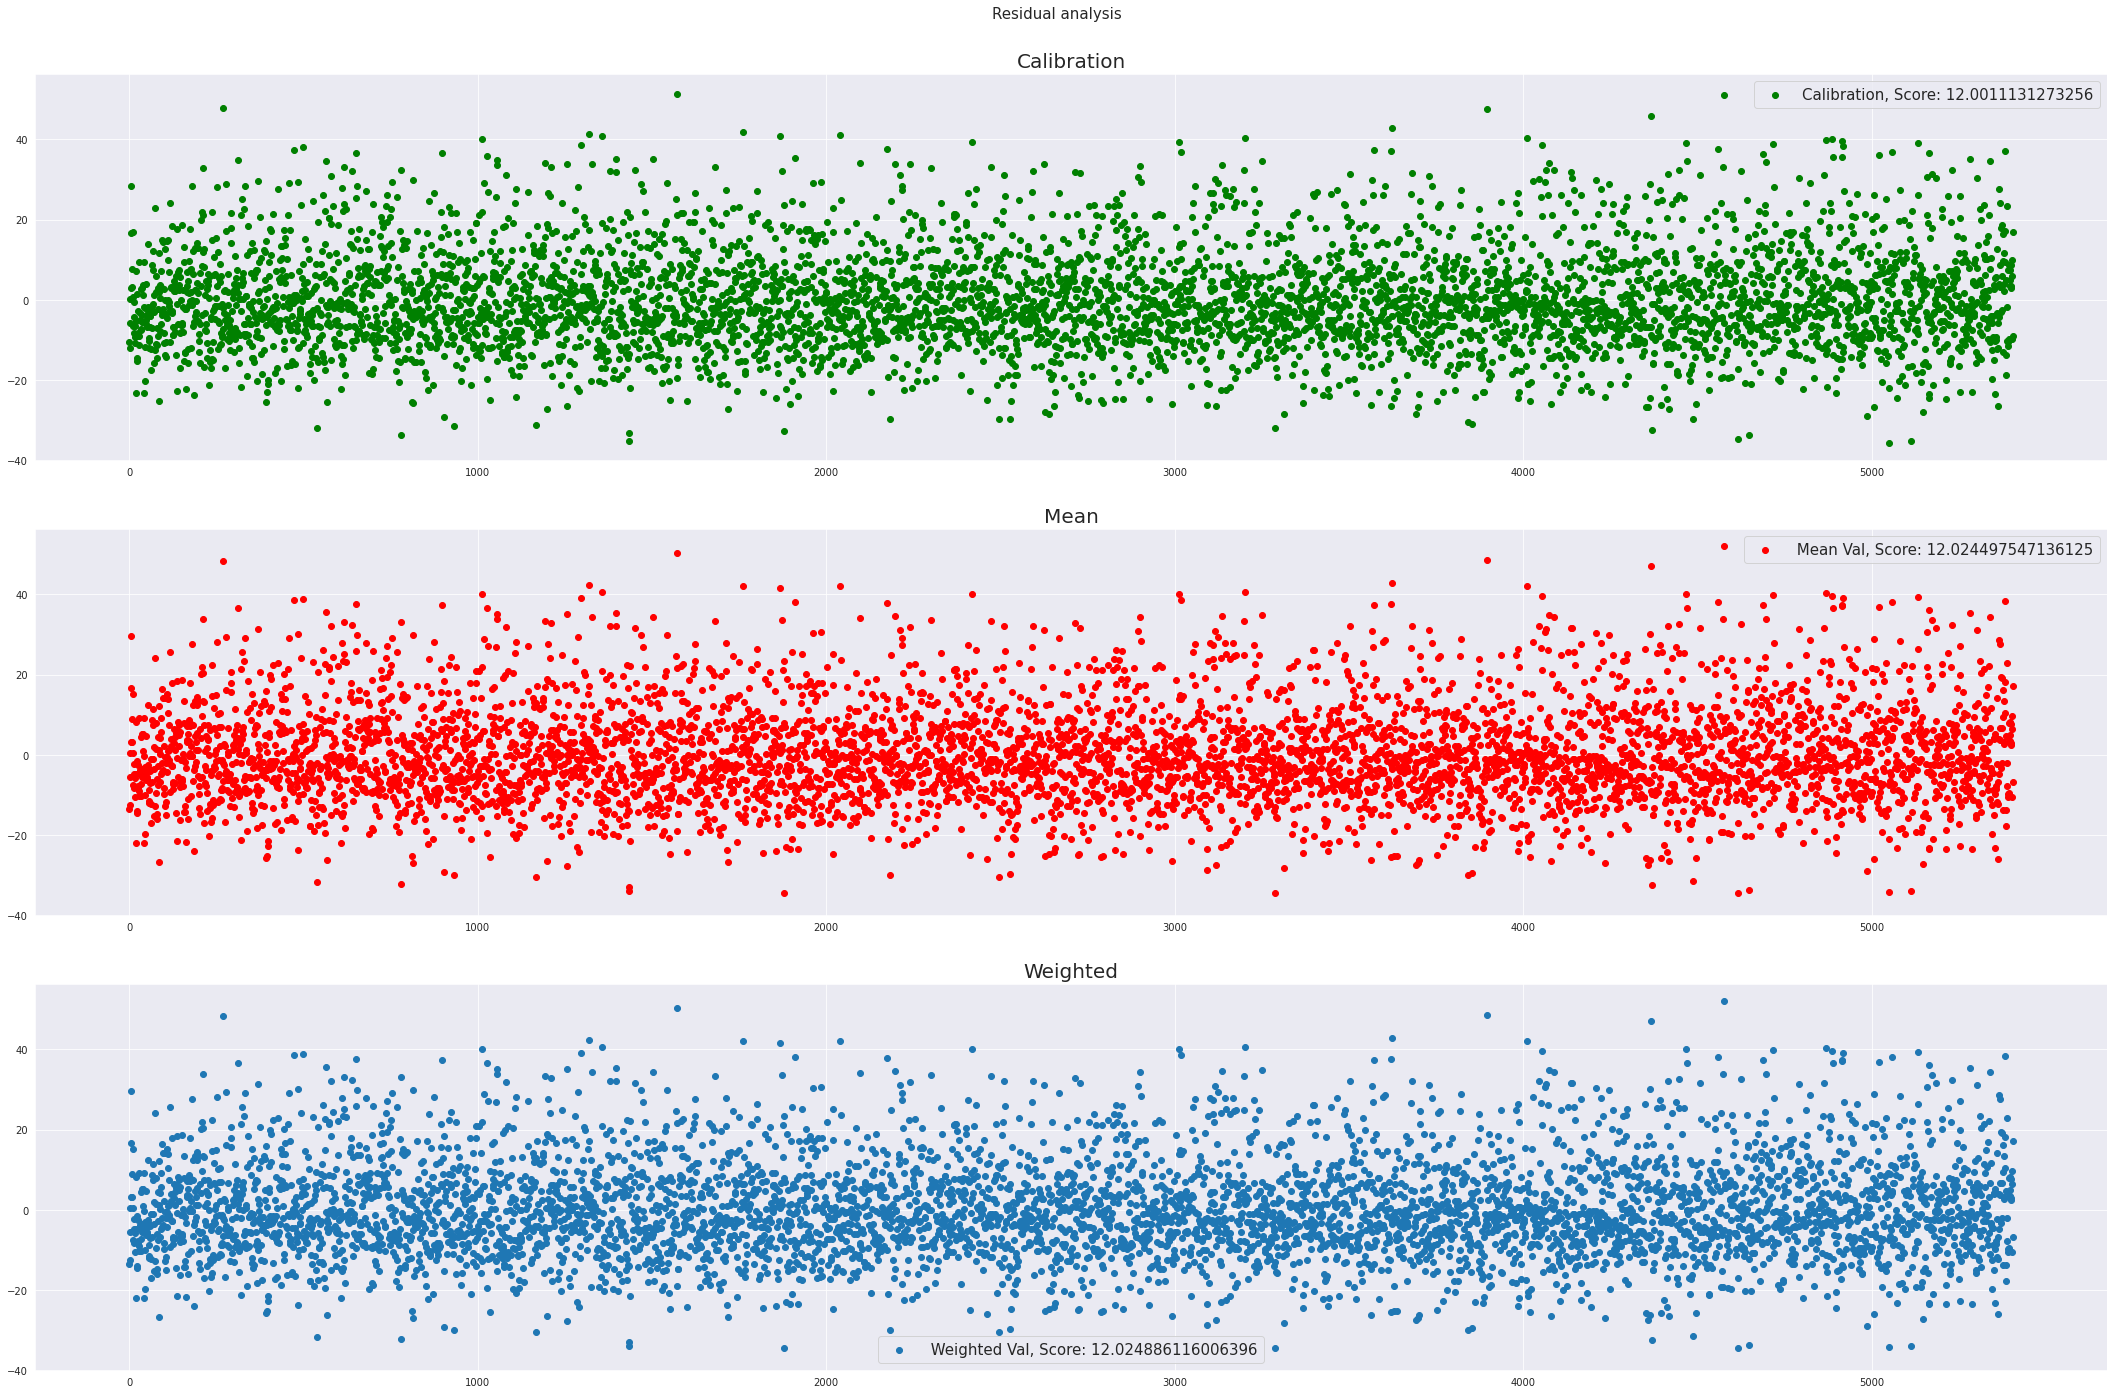

In [43]:
fig, ax = plt.subplots(3,1, figsize = (30,20),sharey = True)
ax = np.ravel(ax)

res_cal = y.values -cal_trn_preds
ax[0].scatter(x = [i for i in range(len(res_cal))], y = res_cal, label = f"Calibration, Score: {cal_score}", color = "g")
ax[0].set_title("Calibration", fontsize = 20)

res_mean = y.values -all_val_preds.mean(axis = 1) 
ax[1].scatter(x = [i for i in range(len(res_mean))], y = res_mean, label = f" Mean Val, Score: {mean_score}", color = "r")
ax[1].set_title("Mean", fontsize = 20)

res_weighted = y.values -weighted_ensemble_val.values
ax[2].scatter(x = [i for i in range(len(res_mean))], y = res_mean, label = f" Weighted Val, Score: {weighted_score}")
ax[2].set_title("Weighted", fontsize = 20)

ax[0].legend(fontsize= 15)
ax[1].legend(fontsize= 15)
ax[2].legend(fontsize= 15)

fig.suptitle("Residual analysis",fontsize= 15)
plt.tight_layout(pad= 3)
plt.show()

In [44]:
print(f"OOF Weighted Score: {weighted_score:.4f}")
print(f"Mean Score: {mean_score:.4f}")
print(f"Optimized Score: {opt_score:.4f}")
print(f"Weighted Score: {weighted_score:.4f}")
print(f"Calibrated Score val: {cal_score:.4f}, trn :{full_fit_RSME:.4f}")

OOF Weighted Score: 12.0249
Mean Score: 12.0245
Optimized Score: 11.9849
Weighted Score: 12.0249
Calibrated Score val: 12.0011, trn :11.9766


In [45]:
print(f"Best CV model: {list(models)[np.argmin(OOF_val_score)]}\n")
for i , name in enumerate(models.keys()):
    print(f"{name}: {OOF_val_score[i]:.4f}")

Best CV model: catboost

LinearRegression: 12.2523
SVR: 12.3820
Ridge: 12.2573
Gradient: 12.1424
lightgbm: 12.0903
xgboost: 12.3469
catboost: 12.0034
ExtraTree: 12.1993
RandomForest: 12.1264
